Dataset Link: https://drive.google.com/drive/folders/1LCM01Tu2v1kItRL_fW66RDEN47ftVloz?usp=drive_link


Choose any 1 dataset of your choice to perform the assignment.

# 1. Import the required libraries 

In [328]:
##---------Type the code below this line------------------##
import os
import gdown
import zipfile
import pandas as pd
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage import color, feature, io
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from skimage.color import rgb2gray
from keras.preprocessing.sequence import pad_sequences

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 2. Data Acquisition 

For the problem identified by you, students have to find the data source themselves from any data source.

## 2.1 Code for converting the above downloaded data into a form suitable for DL



In [234]:
##---------Type the code below this line------------------##

zip_path = '/content/gdrive/MyDrive/scene_classification.zip'
extract_path = '/content/gdrive/MyDrive/extracted_folder_sceneclassification/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [235]:
# List of image file paths and corresponding labels
image_paths = []
labels = []


for root, dirs, files in os.walk(extract_path):
    # Exclude directories starting with a dot
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    for file in files:
        # Exclude files starting with a dot
        if not file.startswith('.'):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

## 2.1 Write your observations from the above.

1. Size of the dataset
2. Plot the distribution of the categories of the target / label.



In [268]:
len(image_paths)

5245

In [269]:
len(labels)

5245

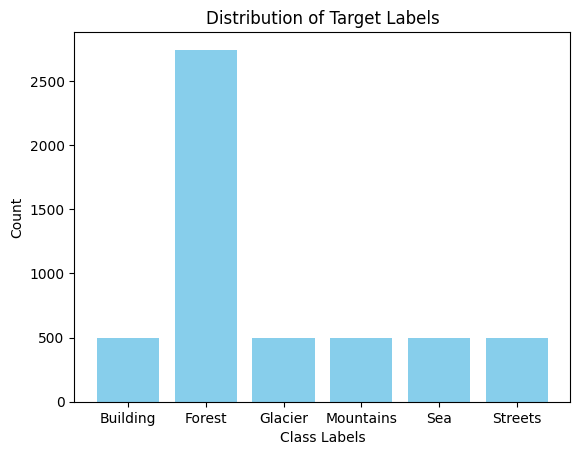

In [267]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'labels' contains your target labels
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Plotting the distribution
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Target Labels')
plt.show()


Fix class imbalance

In [316]:
# Specify the desired number of samples for each class
desired_samples_per_class = 500

# Dictionary to store image paths for each class
class_images = {}

for root, dirs, files in os.walk(extract_path):
    dirs[:] = [d for d in dirs if not d.startswith('.')]
    for file in files:
        if not file.startswith('.'):
            class_name = os.path.basename(root)
            if class_name not in class_images:
                class_images[class_name] = []
            class_images[class_name].append(os.path.join(root, file))

# Create balanced training and testing sets
balanced_image_paths = []
balanced_labels = []

for class_name, images in class_images.items():
    selected_images = np.random.choice(images, size=desired_samples_per_class, replace=False)
    balanced_image_paths.extend(selected_images)
    balanced_labels.extend([class_name] * desired_samples_per_class)

Target/Label distribution after fixing class imbalance

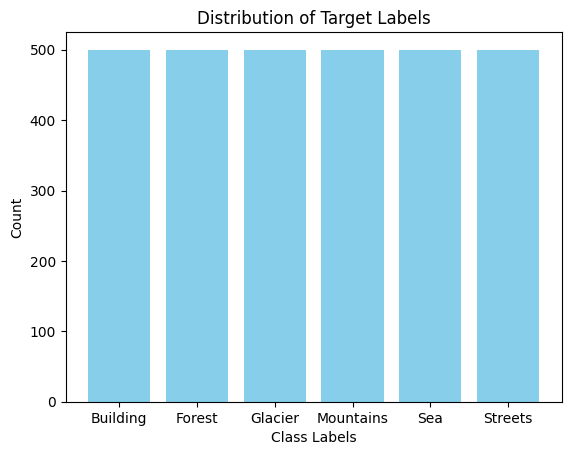

In [317]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'labels' contains your target labels
unique_labels, label_counts = np.unique(balanced_labels, return_counts=True)

# Plotting the distribution
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Target Labels')
plt.show()


# 3. Data Preparation 

Perform the data preprocessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

## 3.1 Split the data into training set and testing set

In [236]:
##---------Type the code below this line------------------##
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.25, random_state=42)

In [239]:
print(len(y_train))

3933


## 3.2 Preprocessing

* Extract the features from the images and concatenate them to create a single for the every images.

* You can choose from the feature processing techniques taught in the class : Low-level Vision: Histogram and Histogram equalization, Gray-scale transformation, Image Smoothing, Connected components in images.
Mid-level Vision:  Edge Detection using Gradients, Sobel, Canny; Line detection using Hough transforms; Semantic information using RANSAC;Image region descriptor using SIFT; Use case: Pedestrian detection Using HoG and SIFT descriptors and SVM

* Create multiple sets of features and store it in seperate dataframes so that you can later use it for training and comparing the models.

* Normalize the DataFrame

* Note : If the feature size is getting too large such that it is not fitting into the RAM of Colab or your system then you can either use PCA or resize the image to smaller dimenssion for reducing the numer of features



In [240]:
##---------Type the answer below this line------------------##
# Data Preparation
# Define a function to extract features from images
class ImageFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_func):
        self.feature_func = feature_func

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for img_path in X:
            img = io.imread(img_path, as_gray=True)
            img_features = self.feature_func(img)
            features.append(img_features)

        return np.array(features)

In [241]:
# Define feature extraction functions
def hog_feature(img):
    hog_descriptor = hog(img, orientations=8, pixels_per_cell=(8,8), cells_per_block=(2, 2),
                            transform_sqrt=True, block_norm='L2')  # Use appropriate parameters
    return hog_descriptor

In [270]:
def sift_feature(img):
    try:
        # Check if the image is empty or has incorrect depth
        if img is None or img.size == 0 or img.dtype != np.uint8:
            return np.zeros(128)

        # Convert the image to uint8 if it's not already
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(img, None)
        return des.flatten() if des is not None else np.zeros(128)
    except Exception as e:
        print("Error:", e)
        return np.zeros(128)

In [242]:
# Create feature sets
hog_extractor = ImageFeatureExtractor(feature_func=hog_feature)

In [271]:
sift_extractor = ImageFeatureExtractor(feature_func=sift_feature)

In [243]:
X_train_hog = hog_extractor.transform(X_train)
X_test_hog = hog_extractor.transform(X_test)

<ipython-input-240-26f3abae5834>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(features)


Padd hog features which are having variable length

In [244]:
X_train_hog = pad_sequences(X_train_hog, maxlen=9248, padding='post', truncating='post', dtype='float32')

In [245]:
X_test_hog = pad_sequences(X_test_hog, maxlen=9248, padding='post', truncating='post', dtype='float32')

In [272]:
X_train_sift = sift_extractor.fit_transform(X_train)
X_test_sift = sift_extractor.transform(X_test)

In [279]:

# # Normalize the features for each image individually
scaler = StandardScaler().fit(X_train_hog)  # Standardize features
X_train_hog_scaled = scaler.transform(X_train_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

In [280]:
# # Normalize the features for each image individually
scaler = StandardScaler().fit(X_train_sift)  # Standardize features
X_train_sift_scaled = scaler.transform(X_train_sift)
X_test_sift_scaled = scaler.transform(X_test_sift)

# 4.1 Model Building 
* Use any 1 classical machine learning algorithm such as : SVM , Xgboost etc. to train the model
* Train the model on different kinds of feature combination dataframe you created in 3.

In [281]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC

In [275]:
np.ndim(y_train)

1

In [282]:
lsvc_hog = SVC(kernel="linear", C=1.0)
lsvc_hog.fit(X_train_hog_scaled,y_train)
print('Coef',lsvc_hog.coef_)
print('Intercept',lsvc_hog.intercept_)

Coef [[ 9.19908104e-05 -3.99009277e-03 -2.87096237e-03 ...  1.76633995e-03
  -5.81843075e-04  5.97530758e-04]
 [ 9.28251433e-04 -2.94134089e-03 -3.57556617e-03 ... -5.83754899e-04
   1.54377505e-04  1.58666639e-04]
 [ 4.11252534e-05 -4.85472525e-04 -3.94796607e-03 ... -9.00394092e-04
  -3.95366353e-04 -3.76254951e-03]
 ...
 [ 2.36254420e-03  9.74408052e-04  4.36098040e-03 ... -3.85611762e-03
  -2.12277795e-03  2.60739898e-03]
 [ 7.72289361e-04  1.22009837e-03  3.60583273e-03 ... -7.40303467e-04
   8.73943319e-04  1.38329550e-03]
 [ 8.15520728e-06  3.73651734e-04  3.13069593e-03 ... -1.89491428e-03
  -4.20423714e-04  5.52829911e-04]]
Intercept [-0.44455467  0.29612551  0.55896706  0.73553749 -0.057765    0.74070041
  0.80506271  0.81689574  0.53221112  0.25948932  0.3124666  -0.26986262
 -0.15558658 -0.44505321 -0.51591755]


In [283]:
lsvc_sift = SVC(kernel="linear", C=1.0)
lsvc_sift.fit(X_train_sift_scaled,y_train)
print('Coef',lsvc_sift.coef_)
print('Intercept',lsvc_sift.intercept_)

Coef [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Intercept [-1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.]


## 4.2 Validation matrix 

Print the model accuracy and F1 Score


In [284]:
##---------Type the answer below this line------------------##
y_pred_hog = lsvc_hog.predict(X_test_hog_scaled)

In [285]:
y_pred_sift = lsvc_sift.predict(X_test_sift_scaled)

In [286]:
accuracy_hog = accuracy_score(y_test, y_pred_hog)
f1_hog = f1_score(y_test, y_pred_hog, average='weighted')

In [287]:
accuracy_sift = accuracy_score(y_test, y_pred_sift)
f1_sift = f1_score(y_test, y_pred_sift, average='weighted')

In [288]:
print("HOG Model:")
print(f"Accuracy: {accuracy_hog}")
print(f"F1 Score: {f1_hog}")



HOG Model:
Accuracy: 0.8048780487804879
F1 Score: 0.8011608166220829


In [289]:
print("\nSIFT Model:")
print(f"Accuracy: {accuracy_sift}")
print(f"F1 Score: {f1_sift}")


SIFT Model:
Accuracy: 0.5373475609756098
F1 Score: 0.37563711501021807


# 5.1 Model Inference

Plot any 5 random test images and their predicted and actual true labels using the model and feature set which gave you the best accuracy/F1 score.


In [306]:
##---------Type the code below this line------------------##
# Model Inference
# Plot 5 random test images and their predicted and actual true labels
def plot_random_images(images, true_labels, predicted_labels, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3), subplot_kw={'xticks':[], 'yticks':[]})
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f'True: {true_labels[i]}\nPred: {predicted_labels[i]}')


In [319]:
# Randomly select 5 test samples
random_indices = np.random.choice(len(X_test), size=5, replace=False)

In [320]:
# Load images for visualization
test_images = [io.imread(X_test[i], as_gray=True) for i in random_indices]
true_labels = [y_test[i] for i in random_indices]


In [321]:
# Predict using the HOG model
predicted_labels_hog = lsvc_hog.predict(X_test_hog_scaled[random_indices])

In [324]:

# Predict using the SIFT model
predicted_labels_sift = lsvc_sift.predict(X_test_sift_scaled[random_indices])

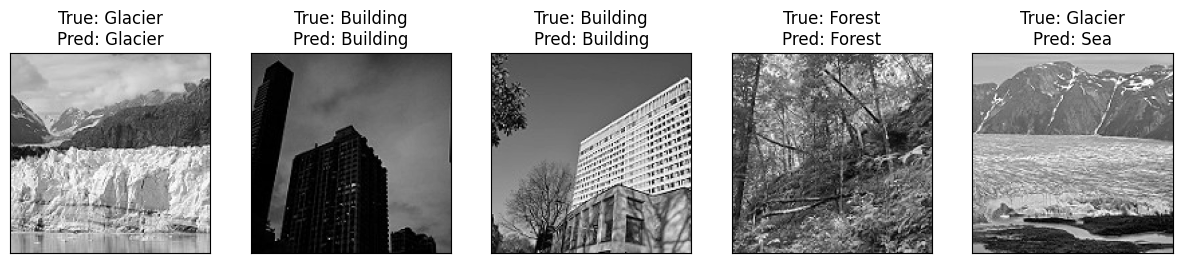

In [323]:
# Plot images and predictions
plot_random_images(test_images, true_labels, predicted_labels_hog, title='')

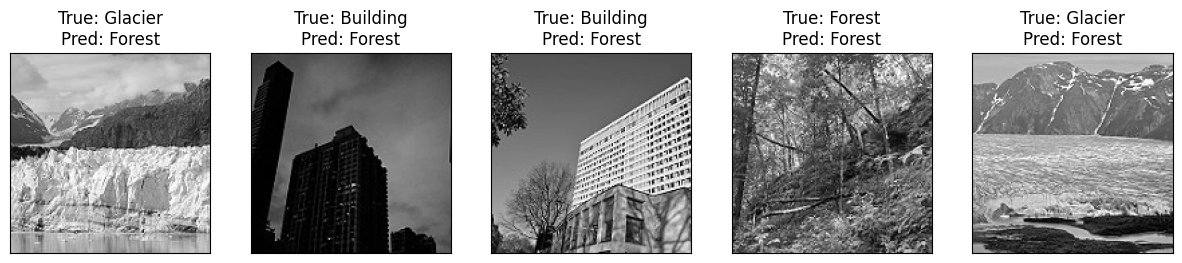

In [325]:
plot_random_images(test_images, true_labels, predicted_labels_sift, title='')

Justify your choice/inution of feature selection based on the performance of model such that why a particualr set have features might have performed well.


In [ ]:
##---------Type the answers below this line------------------##

### NOTE


All Late Submissions will incur a <b>penalty of -2 marks </b>. So submit your assignments on time.

Good Luck

In [160]:
# import cv2
# from skimage.feature import hog
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

In [161]:
# # Data preparation
# def load_images(data_dir, class_labels):
#     """Loads images and their class labels from a directory.

#     Args:
#         data_dir: Directory containing image files.
#         class_labels: List of class labels, each corresponding to a subdirectory.

#     Returns:
#         images: List of loaded images.
#         labels: List of corresponding class labels.
#     """

#     images = []
#     labels = []
#     for class_label in class_labels:
#         class_dir = os.path.join(data_dir, class_label)
#         for filename in os.listdir(class_dir):
#             img = cv2.imread(os.path.join(class_dir, filename))
#             if img is not None:  # Ensure valid image
#                 gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
#                 images.append(gray)
#                 labels.append(class_label)
#     return images, labels

In [162]:
# # Feature extraction
# def extract_hog_features(images, cell_size=(8, 8), bins_per_cell=9, orientations=8):
#     """Extracts Histogram of Oriented Gradients (HOG) features from images.

#     Args:
#         images: List of images.
#         cell_size: Size of cells in the grid.
#         bins_per_cell: Number of histogram bins per cell.
#         orientations: Number of orientations in the histograms.

#     Returns:
#         features: List of HOG feature vectors.
#     """

#     features = []
#     for img in images:
#         hog_descriptor = hog(img, orientations=orientations, pixels_per_cell=cell_size, cells_per_block=(2, 2),
#                             transform_sqrt=True, block_norm='L2')  # Use appropriate parameters
#         features.append(hog_descriptor)
#     return features


In [163]:
# # Training and evaluation
# def train_and_evaluate_svm(features, labels, test_size=0.25):
#     """Trains an SVM classifier and evaluates its performance.

#     Args:
#         features: List of HOG feature vectors.
#         labels: List of corresponding class labels.
#         test_size: Proportion of data for testing (default: 0.25).

#     Returns:
#         clf: Trained SVM classifier.
#         accuracy: Classification accuracy on the test set.
#     """

#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size)
#     scaler = StandardScaler().fit(X_train)  # Standardize features
#     X_train_scaled = scaler.transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     clf = SVC(kernel='linear', C=1.0)  # Use appropriate kernel and hyperparameter
#     clf.fit(X_train_scaled, y_train)

#     accuracy = clf.score(X_test_scaled, y_test)
#     print('Accuracy:', accuracy)
#     return clf, accuracy

In [164]:
# import os
# import cv2
# from skimage.feature import hog
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Example usage (replace with your specific parameters)
# data_dir = extract_path+'subset'
# class_labels = ["Building", "Forest", "Glacier", "Mountains", "Sea", "Streets"]

# images, labels = load_images(data_dir, class_labels)
# features = extract_hog_features(images)



In [165]:
# from keras.preprocessing.sequence import pad_sequences

# # Assuming X_train_hog is a list of 2D arrays with varying lengths
# # Convert it to a list of 2D arrays with padding

# # Pad sequences to a fixed length (use your desired maxlen)
# maxlen = 9248
# features = pad_sequences(features, maxlen=maxlen, padding='post', truncating='post', dtype='float32')
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

In [327]:
# max=len(X_train[1])
# print("standard size", a)
# for p in X_train:
#   g = len(p)
#   if g!=max:
#     print("mismatch", g)
# print("max length", max)

In [143]:
# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# clf = SVC(kernel="linear", C=1.0)
# clf.fit(X_train, y_train)

# accuracy = clf.score(X_test, y_test)
# print("Accuracy:", accuracy)


Accuracy: 0.8003048780487805


In [171]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Additional function to plot 5 random test images with true and predicted labels
# def plot_random_test_images_with_model(clf, X_test, y_test, scaler, original_images, num_images=5):
#     random_indices = np.random.choice(len(X_test), num_images, replace=False)

#     plt.figure(figsize=(15, 3 * num_images))
#     for i, index in enumerate(random_indices, 1):
#         feature_vector = X_test[index]
#         true_label = y_test[index]

#         # Predict the label using the trained SVM
#         predicted_label = clf.predict([feature_vector])[0]

#         # Find the corresponding original image index
#         original_index = np.where(np.array(y_test) == true_label)[0][i - 1]

#         # Plot the original image
#         image = original_images[original_index]
#         plt.subplot(num_images, 1, i)
#         plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying

#         plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
#         plt.axis('off')

#     plt.tight_layout()
#     plt.show()


# Example usage



In [173]:
# original_test_images, _ = load_images(data_dir, class_labels)


In [ ]:
# plot_random_test_images(X_test_scaled, y_test, clf, scaler, original_images=original_test_images)

In [326]:
# # Plotting 5 random test images with true and predicted labels
# plot_random_test_images(X_test_scaled, y_test, clf, scaler, original_images=original_test_images)